# Function imports

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

# Plot formatting

In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Histology visualization

In [6]:
df = pd.read_excel('/Volumes/lab-kohlj/home/shared/projects/HierarchySensoryModality/Data/histology/quantification_NMDA.xlsx')
df['cells_per_mm2'] = df.number_AOB_neurons / (df['area [um2]'] / 1000)

In [16]:
df.groupby('group').count()

,animal_ID,sample_ID,number_AOB_neurons,area [um2],cells_per_mm2
group,,,,,
ctrl,8,8,8,8,8
nmda,9,9,9,9,9


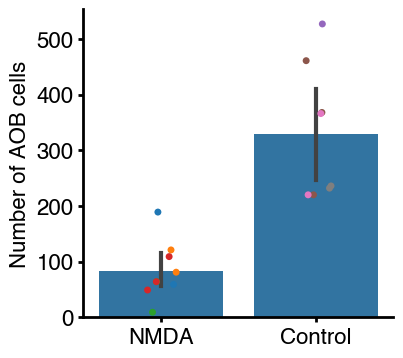

In [119]:
plt.figure(figsize=[4,4])

sns.barplot(df, x='group', y='number_AOB_neurons')
sns.stripplot(df, x='group', y='number_AOB_neurons', hue='animal_ID')

plt.ylabel('Number of AOB cells')
plt.xlabel('')
plt.xticks([0,1], ['NMDA', 'Control'])

plt.legend('', frameon=False)

Text(0.41, 1.5, '**')

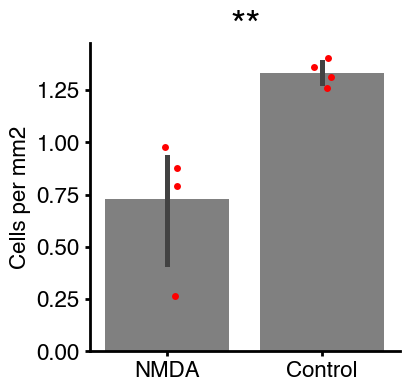

In [7]:
plt.figure(figsize=[4,4])

animal_means = df[['animal_ID', 'group', 'cells_per_mm2']].groupby('animal_ID').agg({'group': 'first', 
                                                                      'cells_per_mm2': 'mean'})

sns.barplot(animal_means, x='group', y='cells_per_mm2', color='grey')
sns.stripplot(animal_means, x='group', y='cells_per_mm2', color='red')
plt.ylabel('Cells per mm2')
plt.xlabel('')
plt.xticks([0,1], ['NMDA', 'Control'])

plt.text(0.41, 1.5, '**', fontsize=28)

#plt.savefig('/Volumes/lab-kohlj/home/shared/projects/HierarchySensoryModality/Plots/Histology/Quantification.png', dpi=300, bbox_inches='tight')

In [8]:
import statsmodels.formula.api as smf

model = smf.mixedlm('cells_per_mm2 ~ group', df, groups='animal_ID').fit()

model.summary()

/Users/borakn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/borakn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/borakn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: cells_per_mm2
No. Observations: 17      Method:             REML         
No. Groups:       8       Scale:              0.1370       
Min. group size:  1       Log-Likelihood:     -8.5255      
Max. group size:  3       Converged:          Yes          
Mean group size:  2.1                                      
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         1.327    0.132 10.057 0.000  1.068  1.585
group[T.nmda]    -0.593    0.182 -3.260 0.001 -0.950 -0.237
animal_ID Var     0.000    0.218                           
===========================================================

"""

# Ablation-Behavior correlation

In [146]:
bdf = pd.read_excel('/Volumes/lab-kohlj/home/users/borakn/Data/Behaviour/Generalisation Test/NMDA + Methimazole/NMDA+methimazole.xlsx')
bdf = bdf.dropna(axis=0).reset_index(drop=True)

bdf['loser cage'] = [{1, 2}.difference({winner}).pop() for n, winner in enumerate(bdf['winner cage'])]

bdf['winner_rank'] = [bdf[f'cage {winner} rank'].loc[n] for n, winner in enumerate(bdf['winner cage'])]
bdf['loser_rank'] = [bdf[f'cage {loser} rank'].loc[n] for n, loser in enumerate(bdf['loser cage'])]

bdf['delta_rank'] = bdf['loser_rank'] - bdf['winner_rank']
bdf['error'] = bdf.delta_rank < 0

error_rates = bdf[['cage 2 ID', 'error']].groupby('cage 2 ID').agg(['sum', 'count'])
error_rates = error_rates['error', 'sum'] / error_rates['error', 'count']
error_rates = error_rates.reset_index().rename(columns={'cage 2 ID': 'animal_ID',
                                                        0: 'error_rate'})
error_rates = error_rates.merge(animal_means, how='left', on='animal_ID')

<Axes: xlabel='cells_per_mm2', ylabel='error_rate'>

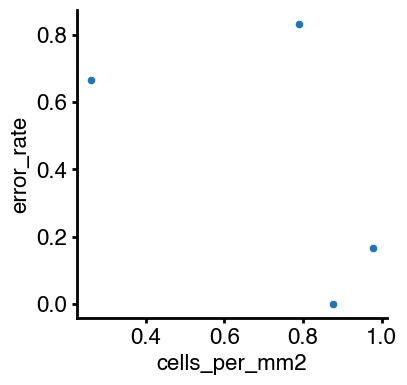

In [153]:
plt.figure(figsize=[4,4])

sns.scatterplot(error_rates, x='cells_per_mm2', y='error_rate')

In [154]:
model = smf.ols('error_rate ~ cells_per_mm2', error_rates).fit()
model.summary()

/Users/borakn/opt/anaconda3/envs/HierarchySensoryModality/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             error_rate   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.9411
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.434
Time:                        12:18:18   Log-Likelihood:               -0.63128
No. Observations:                   4   AIC:                             5.263
Df Residuals:                       2   BIC:                             4.035
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9279      0.564      1.646      0.242      -1.498       3.353
cells_per_mm2    -0.7038      0.726     -0.970      0.434      -3.825       2.418
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.251
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.490
Skew:                           0.737   Prob(JB):                        0.783
Kurtosis:                       2.125   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""